Begun 3/15/24

Notebook to test ell range between 200 and 1000 for nside=512 and to calculate estimators using the unrotated spectra to make sure those are consistent with zero.

It appears that they are consistent with zero. Using this lower ell range (which is theoretically more accurate in anafast) also seems to result in an almost perfectly unbiased TT spectrum. Our angle estimator now has less than 0.07% bias, but the EB estimator on the rotated spectra seems to be biased around the 1% level (perhaps because of greater sensitivity to a single EB spectrum?).

Near the bottom, I also have a test of 100 sims with a constant rotation angle of 3 degrees but different sky realizations each time to see if that affects the EB angle distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180/np.pi
    std_dev *= 180/np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [4]:
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

6.870972823634812


In [5]:
# Doing 500 sims of full sky maps with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
min_ell = 200
max_ell = 1000 

output_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(500))
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
percent_diff_unrot_eb = 100.0*(output_unrot_null_eb_angles_only - rot_degs)/rot_degs

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [2:25:40<00:00, 17.48s/it]


Median of full sky percent error: 0.06255018056748622
Mean of full sky percent error: 0.07330930778145875
Std dev of full sky percent error: 0.15834305237752266


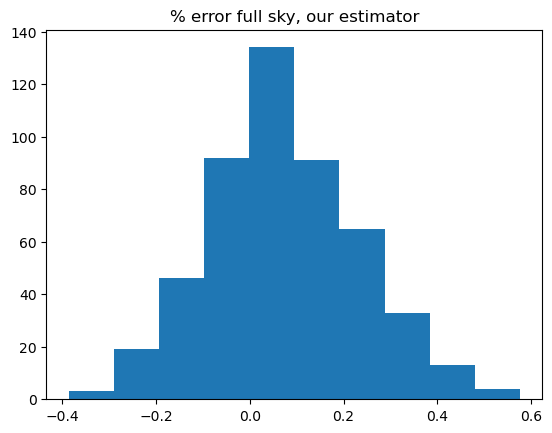

Median of full sky percent error EB estimator: -0.8595211440700194
Mean of full sky percent error EB estimator: -0.6511169368693266
Std dev of full sky percent error EB estimator: 2.1599144816203792


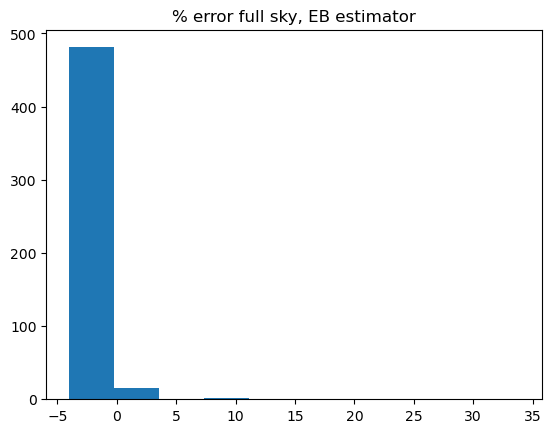

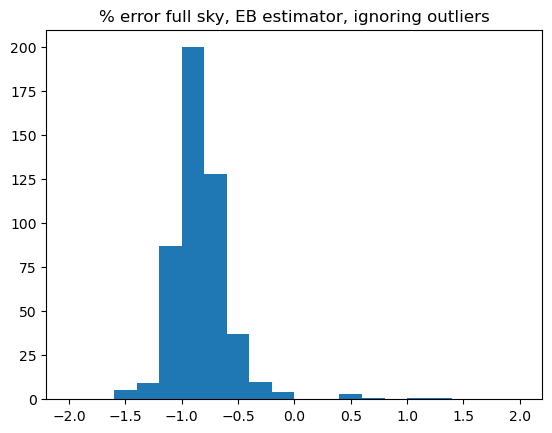

Median of full sky angles Unrot EB estimator: -1.5031564879610045e-05
Mean of full sky angles Unrot EB estimator: 2.3006686095186994e-05
Std dev of full sky angles Unrot EB estimator: 0.0017409848767658068


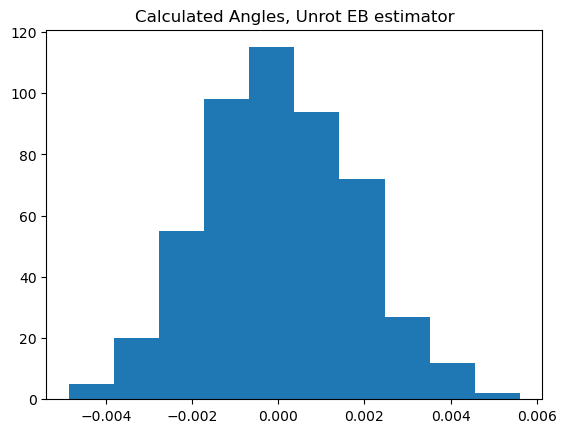

Median of full sky mean TT ratio: 1.0000487625912915
Mean of full sky mean TT ratio: 1.0000121252224015
Std dev of full sky mean TT ratio: 0.0016780433658050134


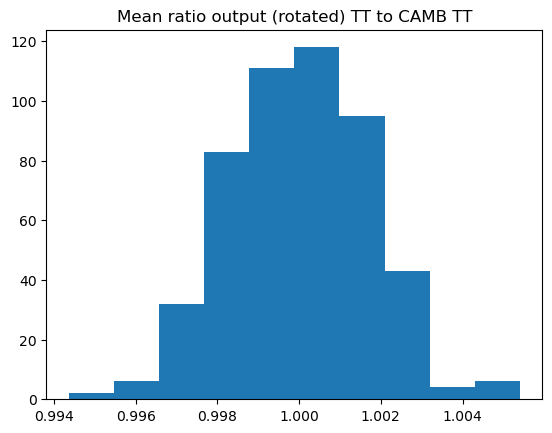

In [21]:
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [13]:
output_spectra = np.array(output_spectra)

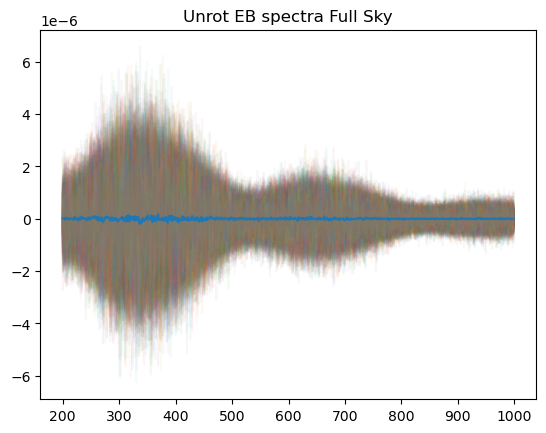

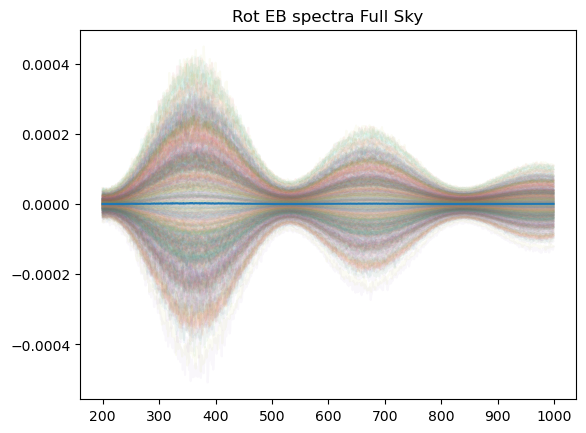

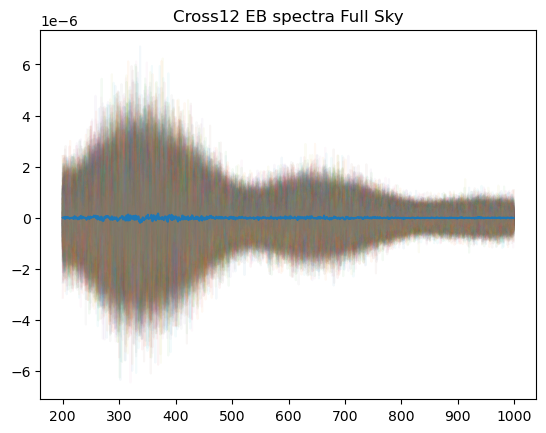

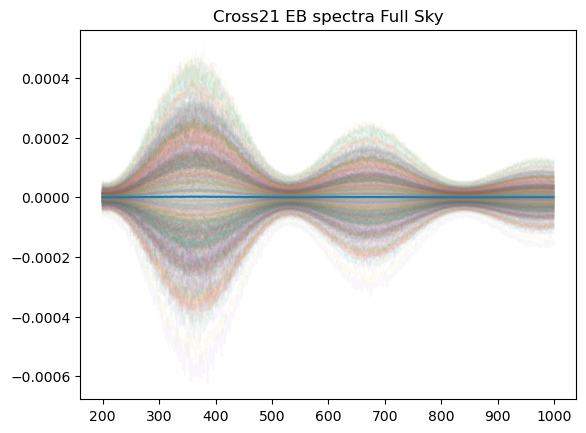

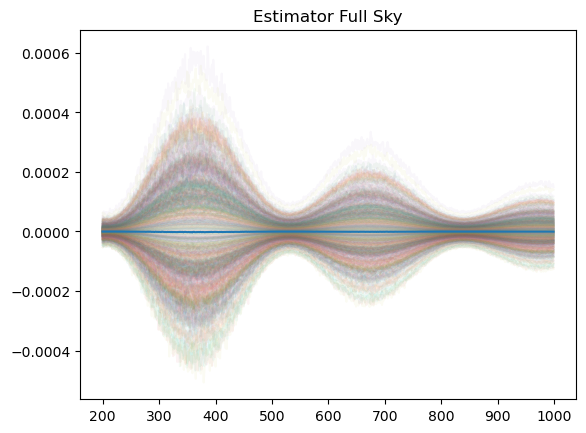

In [20]:
# Plotting all of the EB spectra
mean_EB = np.mean(output_spectra[:,10],axis=0)
mean_EB_rot = np.mean(output_spectra[:,4],axis=0)
mean_EB_cross12 = np.mean(output_spectra[:,16],axis=0)
mean_EB_cross21 = np.mean(output_spectra[:,22],axis=0)
mean_estimator = np.mean(output_spectra[:,16] - output_spectra[:,22], axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][10],alpha=0.05)
plt.title("Unrot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][4],alpha=0.05)
plt.title("Rot EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_rot)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][16],alpha=0.05)
plt.title("Cross12 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross12)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][22],alpha=0.05)
plt.title("Cross21 EB spectra Full Sky")
plt.plot(ell_hp,mean_EB_cross21)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][16]-output_spectra[i][22],alpha=0.05)
plt.title("Estimator Full Sky")
plt.plot(ell_hp,mean_estimator)
#plt.ylim([-0.0005, 0.0005])
plt.show()
plt.close()

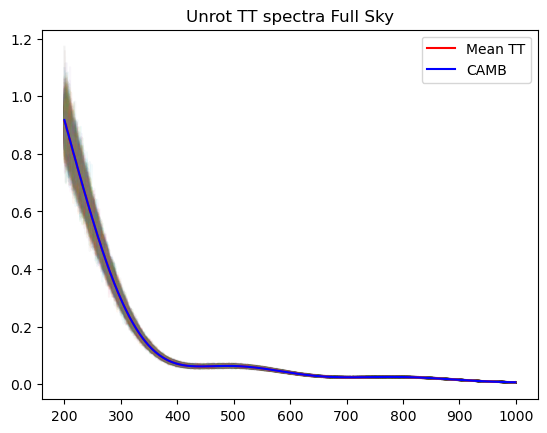

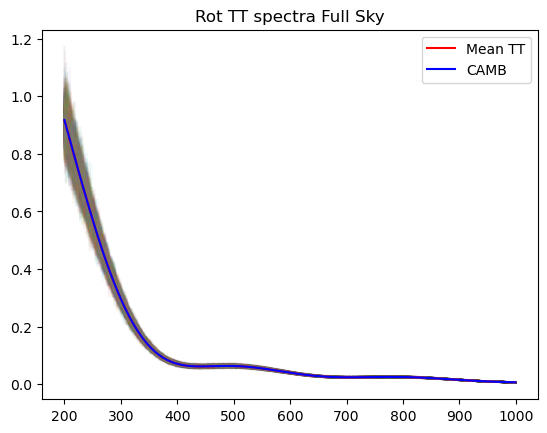

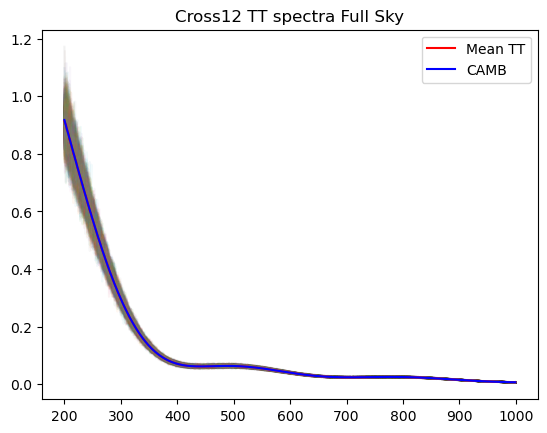

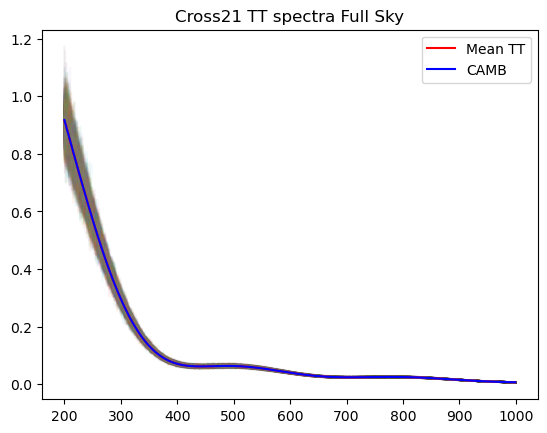

In [16]:
# Plotting all of the TT spectra
mean_TT = np.mean(output_spectra[:,6],axis=0)
mean_TT_rot = np.mean(output_spectra[:,0],axis=0)
mean_TT_cross12 = np.mean(output_spectra[:,12],axis=0)
mean_TT_cross21 = np.mean(output_spectra[:,18],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][6],alpha=0.05)
plt.title("Unrot TT spectra Full Sky")
plt.plot(ell_hp,mean_TT,'r',label='Mean TT')
plt.plot(ell[min_ell:max_ell],ClTT[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][0],alpha=0.05)
plt.title("Rot TT spectra Full Sky")
plt.plot(ell_hp,mean_TT_rot,'r',label='Mean TT')
plt.plot(ell[min_ell:max_ell],ClTT[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][12],alpha=0.05)
plt.title("Cross12 TT spectra Full Sky")
plt.plot(ell_hp,mean_TT_cross12,'r',label='Mean TT')
plt.plot(ell[min_ell:max_ell],ClTT[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][18],alpha=0.05)
plt.title("Cross21 TT spectra Full Sky")
plt.plot(ell_hp,mean_TT_cross21,'r',label='Mean TT')
plt.plot(ell[min_ell:max_ell],ClTT[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

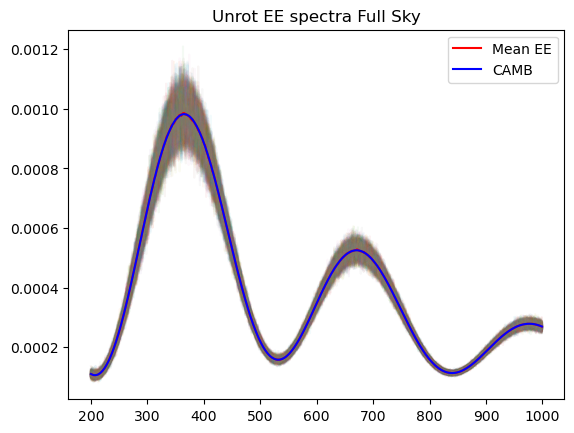

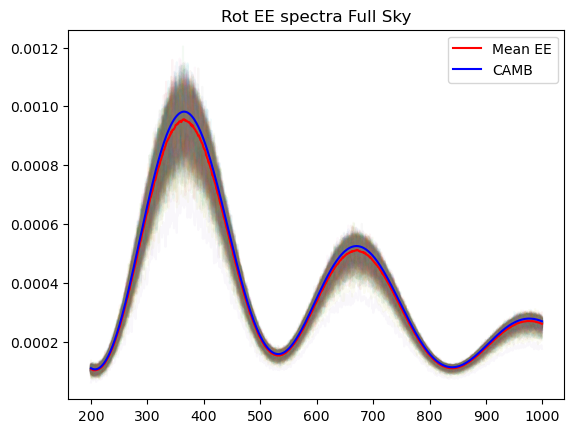

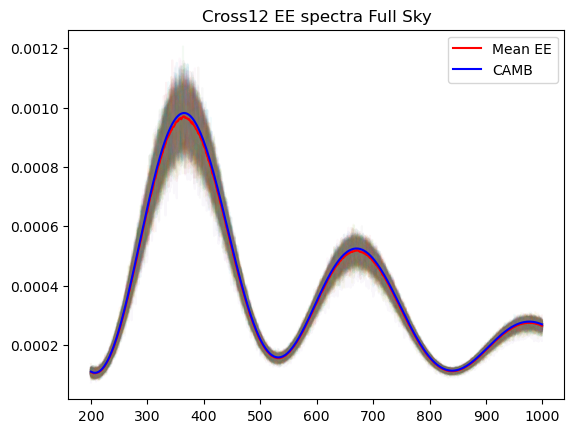

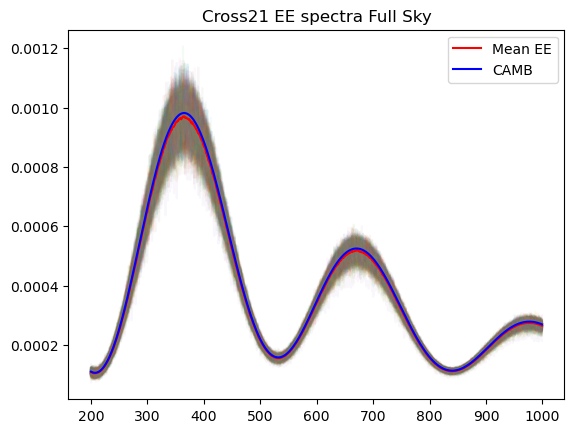

In [17]:
# Plotting all of the EE spectra
mean_EE = np.mean(output_spectra[:,7],axis=0)
mean_EE_rot = np.mean(output_spectra[:,1],axis=0)
mean_EE_cross12 = np.mean(output_spectra[:,13],axis=0)
mean_EE_cross21 = np.mean(output_spectra[:,19],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][7],alpha=0.05)
plt.title("Unrot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][1],alpha=0.05)
plt.title("Rot EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_rot,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][13],alpha=0.05)
plt.title("Cross12 EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_cross12,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][19],alpha=0.05)
plt.title("Cross21 EE spectra Full Sky")
plt.plot(ell_hp,mean_EE_cross21,'r',label='Mean EE')
plt.plot(ell[min_ell:max_ell],ClEE[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

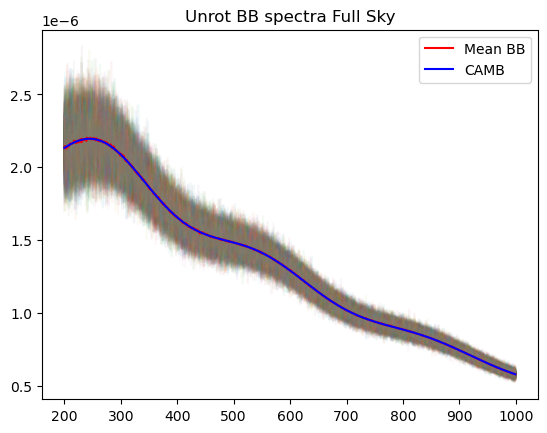

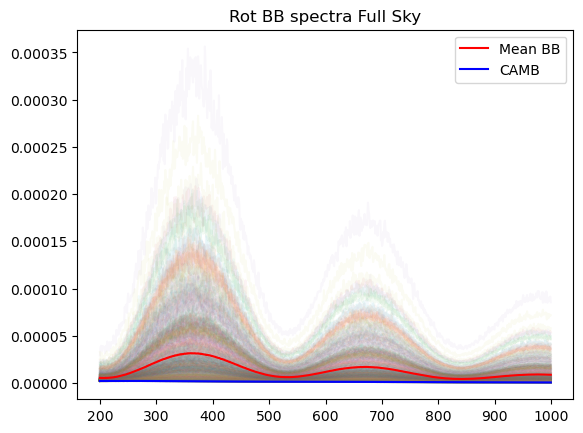

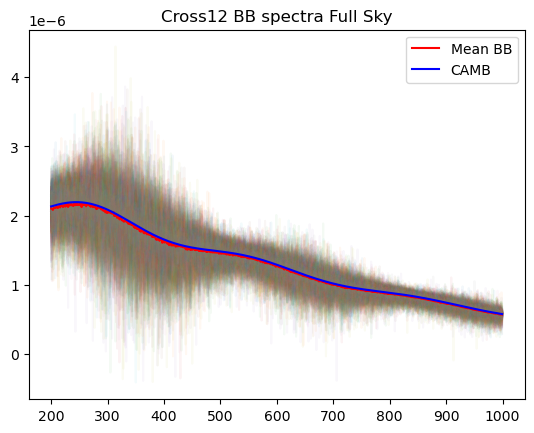

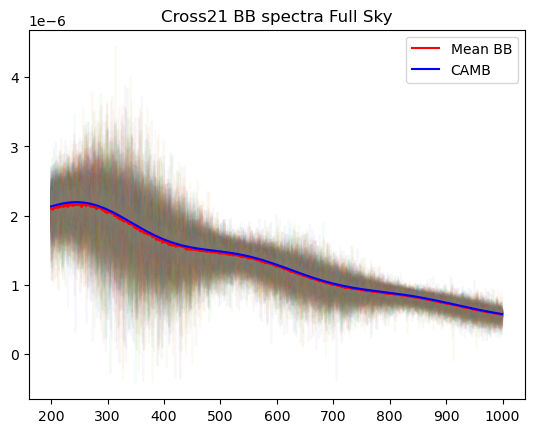

In [18]:
# Plotting all of the BB spectra
mean_BB = np.mean(output_spectra[:,8],axis=0)
mean_BB_rot = np.mean(output_spectra[:,2],axis=0)
mean_BB_cross12 = np.mean(output_spectra[:,14],axis=0)
mean_BB_cross21 = np.mean(output_spectra[:,20],axis=0)

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][8],alpha=0.05)
plt.title("Unrot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][2],alpha=0.05)
plt.title("Rot BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_rot,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][14],alpha=0.05)
plt.title("Cross12 BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_cross12,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

for i in range(len(output_spectra)):
    plt.plot(ell_hp,output_spectra[i][20],alpha=0.05)
plt.title("Cross21 BB spectra Full Sky")
plt.plot(ell_hp,mean_BB_cross21,'r',label='Mean BB')
plt.plot(ell[min_ell:max_ell],ClBB[min_ell:max_ell],'b',label='CAMB')
#plt.ylim([-0.0005, 0.0005])
plt.legend()
plt.show()
plt.close()

In [22]:
# Doing 100 sims of full sky maps with an ell range of 200-1000 with a constant angle of 3 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
min_ell = 200
max_ell = 1000 

output_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(100*[3.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:59<00:00, 17.40s/it]


Median of full sky percent error: 0.10436657684309569
Mean of full sky percent error: 0.08585133492179407
Std dev of full sky percent error: 0.15999048993521076


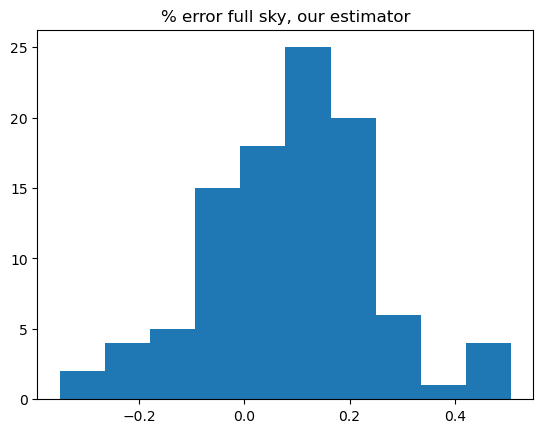

Median of full sky percent error EB estimator: -0.8230831382873394
Mean of full sky percent error EB estimator: -0.8269007559108374
Std dev of full sky percent error EB estimator: 0.1823171552946088


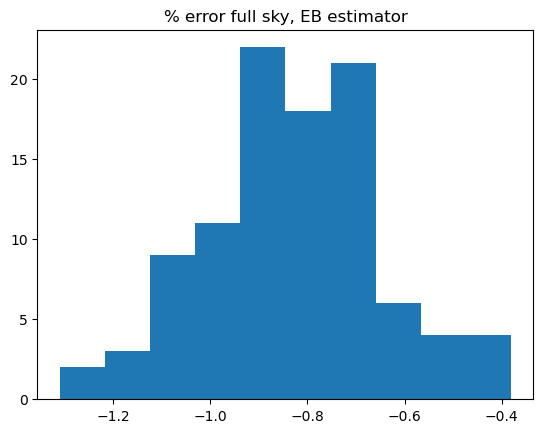

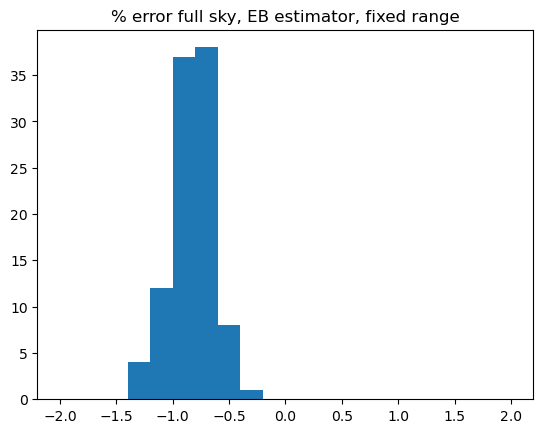

Median of full sky angles Unrot EB estimator: 0.0003854732226157205
Mean of full sky angles Unrot EB estimator: 0.00016708112308698746
Std dev of full sky angles Unrot EB estimator: 0.001720796150639434


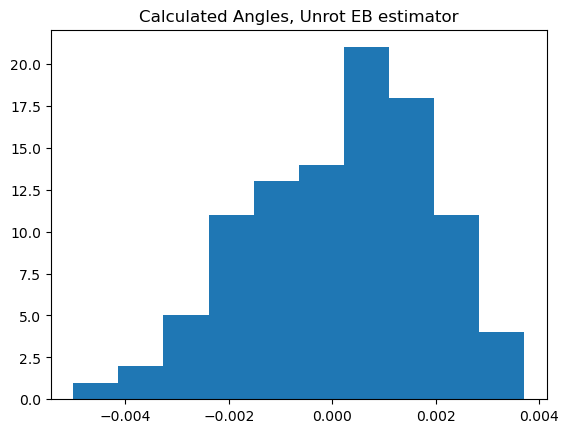

Median of full sky mean TT ratio: 1.0002522472952617
Mean of full sky mean TT ratio: 1.0001634247214846
Std dev of full sky mean TT ratio: 0.0017322539386152307


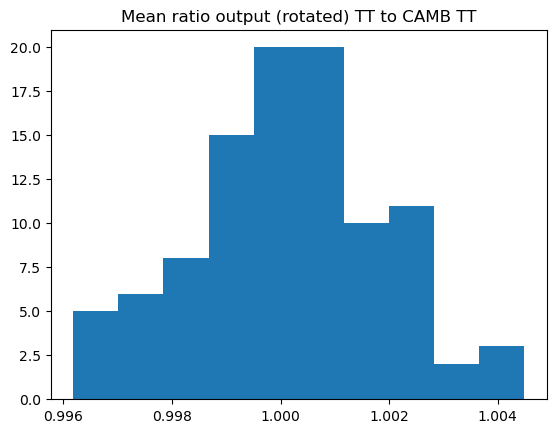

In [24]:
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, fixed range")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [25]:
# Doing 100 sims of full sky maps with an ell range of 200-1000 with a constant angle of 3 deg to
# test the amount of scatter for a fixed angle.
# The difference between the last one and this one is using the unrotated EE spectrum in the estimators
# for the theory curve instead of the CAMB EE spectrum. 
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
min_ell = 200
max_ell = 1000 

output_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(100*[3.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the unrotated EE spectrum as the theory curve for the estimators instead of CAMB EE
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE_unrot,\
                                           angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE_unrot,\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE_unrot,\
                                                          angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [28:39<00:00, 17.20s/it]


Median of full sky percent error: 0.4779554820395937
Mean of full sky percent error: 0.4779511091483302
Std dev of full sky percent error: 0.0018215720704670827


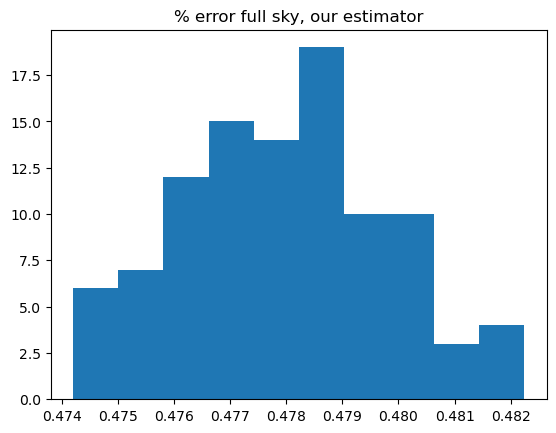

Median of full sky percent error EB estimator: -0.4755548884165369
Mean of full sky percent error EB estimator: -0.47409899552105095
Std dev of full sky percent error EB estimator: 0.07425453723125784


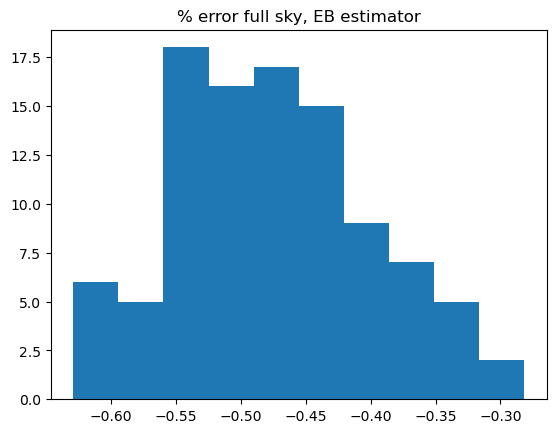

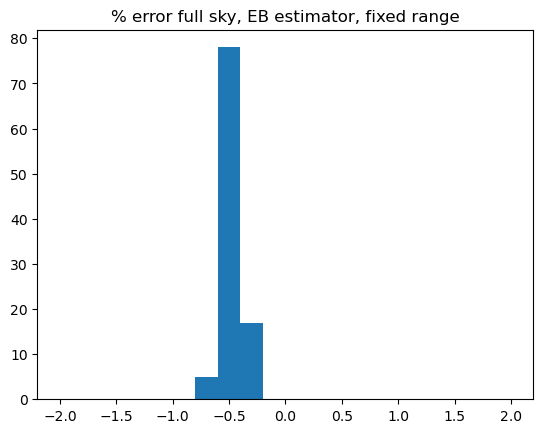

Median of full sky angles Unrot EB estimator: 0.00021630435834755596
Mean of full sky angles Unrot EB estimator: 0.00017686157354294404
Std dev of full sky angles Unrot EB estimator: 0.0019166092682711563


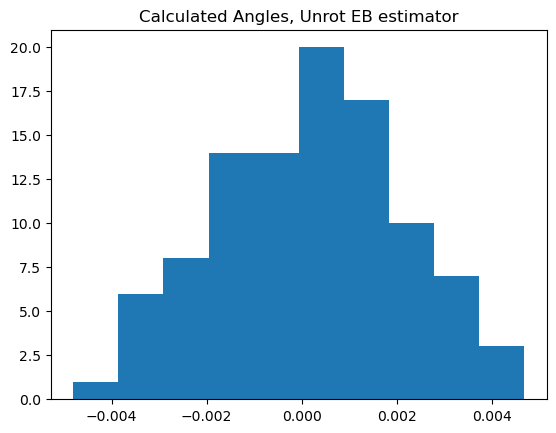

Median of full sky mean TT ratio: 0.9999990937816032
Mean of full sky mean TT ratio: 1.0000619721088426
Std dev of full sky mean TT ratio: 0.0016352095537164836


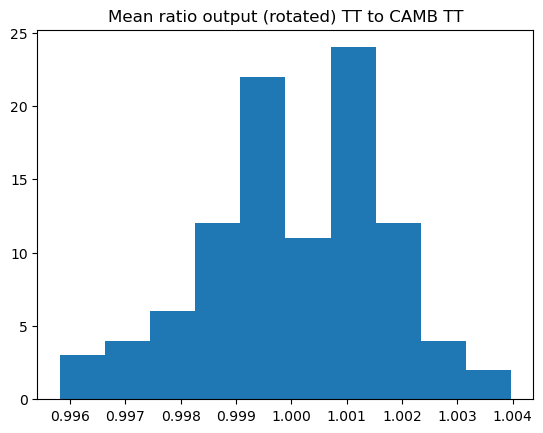

In [26]:
print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, fixed range")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()